In [0]:
import re
import sys
from sklearn.metrics import confusion_matrix
import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from google.colab import files

In [0]:
# Loading the data
uploaded = files.upload()

Saving hygdata_v3.csv to hygdata_v3.csv


In [0]:
df = pd.read_csv('hygdata_v3.csv')

In [0]:
df.head()

,id,hip,hd,hr,gl,bf,proper,ra,dec,dist,pmra,pmdec,rv,mag,absmag,spect,ci,x,y,z,vx,vy,vz,rarad,decrad,pmrarad,pmdecrad,bayer,flam,con,comp,comp_primary,base,lum,var,var_min,var_max
0,0,NaN,NaN,NaN,NaN,NaN,Sol,0.000000,0.000000,0.0000,0.00,0.00,0.0,-26.70,4.850,G2V,0.656,0.000005,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,1,0,NaN,1.000000,NaN,NaN,NaN
1,1,1.0,224700.0,NaN,NaN,NaN,NaN,0.000060,1.089009,219.7802,-5.20,-1.88,0.0,9.10,2.390,F5,0.482,219.740502,0.003449,4.177065,4.000000e-08,-0.000006,-2.000000e-06,0.000016,0.019007,-2.521031e-08,-9.114497e-09,NaN,NaN,Psc,1,1,NaN,9.638290,NaN,NaN,NaN
2,2,2.0,224690.0,NaN,NaN,NaN,NaN,0.000283,-19.498840,47.9616,181.21,-0.93,0.0,9.27,5.866,K3V,0.999,45.210918,0.003365,-16.008996,-7.000000e-08,0.000042,-2.000000e-07,0.000074,-0.340319,8.785309e-07,-4.508767e-09,NaN,NaN,Cet,1,2,NaN,0.392283,NaN,NaN,NaN
3,3,3.0,224699.0,NaN,NaN,NaN,NaN,0.000335,38.859279,442.4779,5.24,-2.91,0.0,6.61,-1.619,B9,-0.019,344.552785,0.030213,277.614965,3.920000e-06,0.000011,-4.860000e-06,0.000088,0.678222,2.540424e-08,-1.410808e-08,NaN,NaN,And,1,3,NaN,386.901132,NaN,NaN,NaN
4,4,4.0,224707.0,NaN,NaN,NaN,NaN,0.000569,-51.893546,134.2282,62.85,0.16,0.0,8.06,2.421,F0V,0.370,82.835513,0.012476,-105.619540,8.000000e-08,0.000041,6.000000e-08,0.000149,-0.905713,3.047054e-07,7.757010e-10,NaN,NaN,Phe,1,4,NaN,9.366989,NaN,NaN,NaN


In [0]:
%matplotlib inline
sns.set(style='darkgrid')
sns.set_palette('PuBuGn_d')

id              False
hip              True
hd               True
hr               True
gl               True
bf               True
proper           True
ra              False
dec             False
dist            False
pmra            False
pmdec           False
rv              False
mag             False
absmag          False
spect            True
ci               True
x               False
y               False
z               False
vx              False
vy              False
vz              False
rarad           False
decrad          False
pmrarad         False
pmdecrad        False
bayer            True
flam             True
con              True
comp            False
comp_primary    False
base             True
lum             False
var              True
var_min          True
var_max          True
dtype: bool

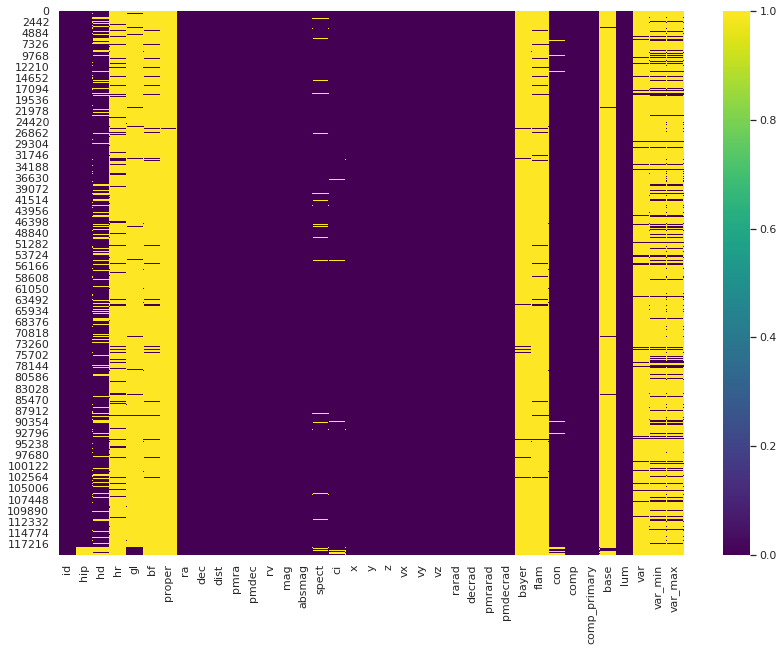

In [0]:
df.isnull().sum()
plt.figure(figsize=(14, 10))
sns.heatmap(df.isnull(), cmap='viridis')
df.isnull().any()

In [0]:
df.shape

(119614, 37)

In [0]:
print(list(df.columns))

['id', 'hip', 'hd', 'hr', 'gl', 'bf', 'proper', 'ra', 'dec', 'dist', 'pmra', 'pmdec', 'rv', 'mag', 'absmag', 'spect', 'ci', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'rarad', 'decrad', 'pmrarad', 'pmdecrad', 'bayer', 'flam', 'con', 'comp', 'comp_primary', 'base', 'lum', 'var', 'var_min', 'var_max']


In [0]:
df.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index()

,feature_type,count
0,int64,3
1,float64,26
2,object,8


In [0]:
#Finding missing columns and their types

df_dtypes = pd.merge(df.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(),
                     df.dtypes.to_frame('feature_type').reset_index(),
                     on = 'index',
                     how = 'inner')

In [0]:
df_dtypes.sort_values(['missing_value', 'feature_type'])

,index,missing_value,feature_type
0,id,0,int64
2,comp_primary,0,int64
3,comp,0,int64
1,lum,0,float64
4,pmdecrad,0,float64
5,pmrarad,0,float64
6,decrad,0,float64
7,rarad,0,float64
8,vz,0,float64
9,vy,0,float64


In [0]:
#Check columns have more than 110000 missing values

missing_df = df.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index()

In [0]:
miss_11 = list(missing_df[missing_df.missing_value >= 110000]['index'])

In [0]:
print(len(miss_11))

8


In [0]:
print(sorted(miss_11))

['base', 'bayer', 'bf', 'flam', 'gl', 'hr', 'proper', 'var']


In [0]:
df.drop(miss_11, axis = 1, inplace = True)

In [0]:
df.head()

,id,hip,hd,ra,dec,dist,pmra,pmdec,rv,mag,absmag,spect,ci,x,y,z,vx,vy,vz,rarad,decrad,pmrarad,pmdecrad,con,comp,comp_primary,lum,var_min,var_max
0,0,NaN,NaN,0.000000,0.000000,0.0000,0.00,0.00,0.0,-26.70,4.850,G2V,0.656,0.000005,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,NaN,1,0,1.000000,NaN,NaN
1,1,1.0,224700.0,0.000060,1.089009,219.7802,-5.20,-1.88,0.0,9.10,2.390,F5,0.482,219.740502,0.003449,4.177065,4.000000e-08,-0.000006,-2.000000e-06,0.000016,0.019007,-2.521031e-08,-9.114497e-09,Psc,1,1,9.638290,NaN,NaN
2,2,2.0,224690.0,0.000283,-19.498840,47.9616,181.21,-0.93,0.0,9.27,5.866,K3V,0.999,45.210918,0.003365,-16.008996,-7.000000e-08,0.000042,-2.000000e-07,0.000074,-0.340319,8.785309e-07,-4.508767e-09,Cet,1,2,0.392283,NaN,NaN
3,3,3.0,224699.0,0.000335,38.859279,442.4779,5.24,-2.91,0.0,6.61,-1.619,B9,-0.019,344.552785,0.030213,277.614965,3.920000e-06,0.000011,-4.860000e-06,0.000088,0.678222,2.540424e-08,-1.410808e-08,And,1,3,386.901132,NaN,NaN
4,4,4.0,224707.0,0.000569,-51.893546,134.2282,62.85,0.16,0.0,8.06,2.421,F0V,0.370,82.835513,0.012476,-105.619540,8.000000e-08,0.000041,6.000000e-08,0.000149,-0.905713,3.047054e-07,7.757010e-10,Phe,1,4,9.366989,NaN,NaN


In [0]:
#Remove constant features

def find_constant_features(dataFrame):
  const_features = []
  for column in list(dataFrame.columns):
    if dataFrame[column].unique().size < 2:
      const_features.append(column)
  return const_features

In [0]:
const_features = find_constant_features(df)

In [0]:
const_features

[]

In [0]:
df.shape

(119614, 29)

In [0]:
#Remove duplicate rows

df.drop_duplicates(inplace = True)

In [0]:
df.shape

(119614, 29)

In [0]:
#Remove duplicate columns

def duplicate_columns(frame):
  groups = frame.columns.to_series().groupby(frame.dtypes).groups
  dups = []

  for t, v in groups.items():

    cs = frame[v].columns
    vs = frame[v]
    lcs = len(cs)

    for i in range(lcs):
      ia = vs.iloc[:,i].values
      for j in range(i+1, lcs):
        ja = vs.iloc[:,j].values
        if np.array_equal(ia, ja):
          dups.append(cs[i])
          break

  return dups

In [0]:
duplicate_cols = duplicate_columns(df)

In [0]:
duplicate_cols

[]

In [0]:
!pip install --user --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.1)


In [0]:
!whoami

root


In [0]:
import sys
sys.path.insert(0,"/gpfs/fs01/user/root/.local/lib/python2.7/site-packages")

In [0]:
import sklearn
sklearn.__version__

'0.22.1'

In [0]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values = "NaN", strategy = "mean")

In [0]:
# Split data into training and testing sets
features = [
'id',
'hip',
'hd',
'ra',
'dec',
'dist',
'pmra',
'pmdec',
'rv',
'mag',
'absmag',
'spect',
'ci',
'x',
'y',
'z',
'vx',
'vy',
'vz',
'rarad',
'decrad',
'pmrarad',
'pmdecrad',
'con',
'comp',
'comp_primary',
'lum',
'var_min',
'var_max',
]

#'Last Updated', 

X = df[features]
y = df['Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 25)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


# Look at the closest neighbors
n_size = None
n_best = None
max_acc = 0
for n_size in range(1, 30):
    print("If n is", n_size)
    model = KNeighborsRegressor(n_neighbors=n_size)
    # Calculate the mean accuracy of the KNN model
    model.fit(X_train, y_train)
    accuracy = model.score(X_test,y_test)
    if(max_acc < accuracy):
        max_acc = accuracy
        n_best = n_size
    print('Accuracy: ' + str(np.round(accuracy*100, 2)) + '%')
    

NameError: ignored

In [0]:
print("If n is", n_best)
model = KNeighborsRegressor(n_neighbors=n_best)
# Calculate the mean accuracy of the KNN model
model.fit(X_train, y_train)
accuracy = model.score(X_test,y_test)
print('Accuracy: ' + str(np.round(accuracy*100, 2)) + '%')

NameError: ignored